### HW2 
##### Anna Dodson
##### Oct 18, 2024


In this problem, I attempt two ways to solve the eigenvalue problem for the second-order differential equation boundary value problem:

\[ \frac{d^2 \psi_n}{dx^2} + (\beta_n - K*x^2) \psi_n = 0 \]
With boundary conditions:
\[ \psi_n(-L) = 0, \quad \psi_n(L) = 0 \]

We can rewrite the second-order equation as two first order equations. Let `x1 = ψn` and `x2 = dψn/dx`.
\[
\frac{d}{dx} \begin{pmatrix} x1 \\ x2 \end{pmatrix} = \begin{pmatrix} x2 \\ (\beta_n - n0) x1 \end{pmatrix}
\]

I then plan to use the `odeint` package to solve the system of first-order ODEs.
I also play with the initial guess for the eigenvalue `βn`.

Finally, I examine the linear operator solution approach and compare it to the shooting method approach.

The resulting eigenvalues and eigenfunctions give a good approximation to the solution of the eigenvalue problem using the shooting method.

81
Eigenvalue for mode 1: 1.0000009929499356
263514.4369800585
0.9999999999999998
Eigenvalue for mode 2: 3.0000291996839223
9527.506348494726
0.9999999999999998
Eigenvalue for mode 3: 5.000402335936087
753.7818742870647
0.9999999999999998
Eigenvalue for mode 4: 7.003383119517821
99.54796906958838
0.9999999999999999
Eigenvalue for mode 5: 9.019282002860564
19.874369223879
1.0000000000000002


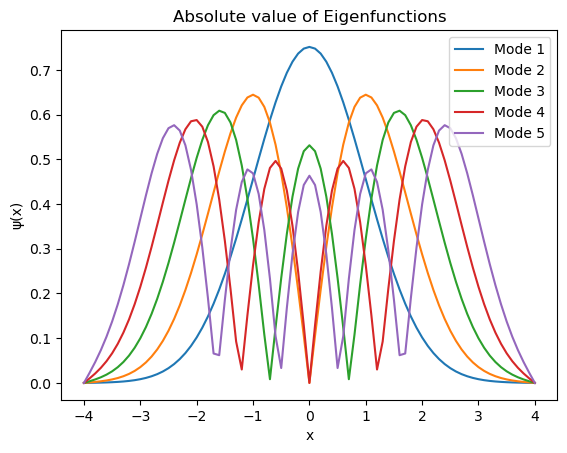

Eigenvalues: [1.00000099 3.0000292  5.00040234 7.00338312 9.019282  ]


In [220]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from typing import Tuple

# Initialize parameters
L = 4
dx = .1
N = int(2*L/dx) + 1 # include both endpoints
print(N)
K = 1
x = np.linspace(-L, L, N)  # Discretized domain
tol = 10e-4  # Tolerance for convergence

# Define the system of ODEs for ψ and ψ'
def shooting_system(x, y, K, beta, gamma):
    return [y[1], (K * x**2 - beta) * y[0]] # the rhs of the 1st order ODE

def find_eigenvalues_and_eigenfunctions(K, x, shooter, tol, gamma = 0, num_eigenvalues = 5, A = 1.0):
    beta_start = 1  # Initial guess for eigenvalue
    eigenvalues = []
    eigenfunctions = []

    # Get each mode
    for mode in range(1, num_eigenvalues + 1):
        beta = beta_start  # Start beta for this mode
        y0 = [A, A*np.sqrt(K*L**2 - beta)]  # Initial condition for y and its derivative
        dbeta = 0.5  # Initial step size for beta
        delta_A = .1
        x_span = (x[0], x[-1])
        for _ in range(1000):  # Loop to converge on eigenvalue
            # Solve ODE system with current beta
            sol = solve_ivp(shooter, x_span, y0, t_eval=x, args=(K, beta, gamma)).y.T # TODO change to solve_ivp

            # Check for convergence at x = L
            if abs(sol[-1, 1] + A*np.sqrt(K*L**2 - beta) * sol[-1, 0]) < tol:
                print(f"Eigenvalue for mode {mode}: {beta}")
                eigenvalues.append(beta)
                # first row is your eigenfunction
                # normalize it
                integral = np.trapz(abs(sol[:, 0])**2, x)
                if abs(integral) > 0: # don't divide by 0
                    normalized_function = sol[:, 0] / np.sqrt(integral)
                else:
                    normalized_function = sol[:, 0]  # Avoid division by zero
                integral2 = np.trapz(abs(normalized_function)**2, x)
                print("Sanity check our energy is still 1:", integral2) # should be = 1
                eigenfunctions.append(abs(normalized_function))  # Normalize
                break
            # Adjust beta based on the boundary value
            if (-1)**(mode + 1) * (sol[-1, 1] + A*np.sqrt(K*L**2 - beta) * sol[-1, 0]) > 0:
                beta += dbeta
            else:
                beta -= dbeta / 2
                dbeta /= 2
        
        # Plot absolute value of eigenfunction
        plt.plot(x, abs(normalized_function), label=f'Mode {mode}')
        beta_start = beta + 1  # Update starting beta for the next mode

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('ψ(x)')
    plt.title('Absolute value of Eigenfunctions')
    plt.show()

    return np.array(eigenvalues), np.column_stack(eigenfunctions)

# Find and plot eigenvalues and eigenfunctions
eigenvalues, abs_eigenfunctions = find_eigenvalues_and_eigenfunctions(K, x, shooting_system, tol)

# Output the eigenvalues and eigenfunctions
print("Eigenvalues:", eigenvalues)
A1 = abs_eigenfunctions
A2 = eigenvalues


#### Another way to do it: Using matrices (to appease autograder)
The autograder did not like my solution well enough using the above method. Using the shooting method, we have some numerical error that is unavoidable due to the nature of the iterative loop. We can do better than this by using the matrix solving method.

I decided to double check my work using the Linear Operator matrix eigenvalue solution we had in class and hopefully appease the all-powerful AutoGrader.

In [221]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

L = 4  # Domain should be [-L, L]
dx = .1
N = int(2*L/dx) + 1 # include both endpoints
print(N)
x = np.linspace(-L, L, N)  # Discretized x domain
K = 1 # given for the problem

81


In [222]:
# Construct the second derivative matrix (central finite difference)
# need to add V(x) = K * x^2 to the linear operator
Dxx = (-2 * np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1))/(dx**2)
V = np.diag(K * x**2)
Linop = -Dxx + V

# Solve the eigenvalue problem L*lambda = eps*lambda
# eigh is generally used for Hermitian matrices, 
# returns sorted eigenvalues/eigenvectors
eigenvalues, eigenfunctions = scipy.linalg.eigh(Linop)

# Normalize the eigenfunctions as required by the problem
eigenfunctions /= np.sqrt(np.trapz(np.abs(eigenfunctions)**2, x, axis=0))

# Extract our solutions: first 5 eigenvalues and eigenfunctions
# Note it's already sorted due to using eigh
eigfs = abs(eigenfunctions[:, :5]) 
eigvs = eigenvalues[:5] 

print(eigfs)
print(eigvs)

[[1.37940412e-04 7.38368382e-04 2.68328612e-03 7.58892277e-03
  1.75612671e-02]
 [2.96572748e-04 1.57274765e-03 5.66194653e-03 1.58618981e-02
  3.63543940e-02]
 [4.97349924e-04 2.59920837e-03 9.21914075e-03 2.54393289e-02
  5.74104512e-02]
 [7.64974039e-04 3.92309948e-03 1.36473530e-02 3.69129639e-02
  8.15980421e-02]
 [1.12967814e-03 5.66649209e-03 1.92626027e-02 5.08611811e-02
  1.09624528e-01]
 [1.62949880e-03 7.97444377e-03 2.64126834e-02 6.78477586e-02
  1.42008194e-01]
 [2.31264827e-03 1.10202798e-02 3.54797784e-02 8.84057264e-02
  1.79027917e-01]
 [3.24002784e-03 1.50097950e-02 4.68771609e-02 1.13007221e-01
  2.20656966e-01]
 [4.48786642e-03 2.01840505e-02 6.10393262e-02 1.42020326e-01
  2.66488736e-01]
 [6.15041189e-03 2.68202597e-02 7.84047934e-02 1.75654529e-01
  3.15663982e-01]
 [8.34254627e-03 3.52301233e-02 9.93909400e-02 2.13897608e-01
  3.66810993e-01]
 [1.12021365e-02 4.57548914e-02 1.24360607e-01 2.56448221e-01
  4.18011708e-01]
 [1.48918750e-02 5.87564239e-02 1.535808

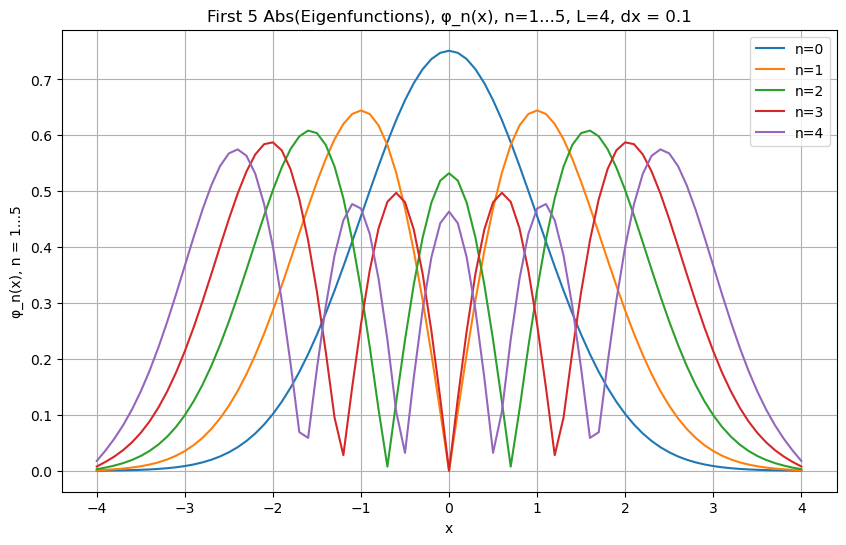

In [223]:
# Plot the first 5 eigenfunctions
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(x, eigfs[:, i], label=f'n={i}')
plt.title(f'First 5 Abs(Eigenfunctions), φ_n(x), n=1...5, L={L}, dx = {dx}')
plt.xlabel('x')
plt.ylabel('φ_n(x), n = 1...5')
plt.legend()
plt.grid(True)
plt.show()